In [ ]:
!pip install scvi-tools -U
!pip install scanpy
!pip3 install leidenalg
#!pip install git+https://github.com/theislab/scvelo

     |████████████████████████████████| 231 kB 8.8 MB/s 
     |████████████████████████████████| 127 kB 54.3 MB/s 
     |████████████████████████████████| 813 kB 68.5 MB/s 
     |████████████████████████████████| 678 kB 61.9 MB/s 
     |████████████████████████████████| 242 kB 70.4 MB/s 
     |████████████████████████████████| 212 kB 84.7 MB/s 
     |████████████████████████████████| 329 kB 73.4 MB/s 
     |████████████████████████████████| 636 kB 67.0 MB/s 
     |████████████████████████████████| 125 kB 67.3 MB/s 
     |████████████████████████████████| 829 kB 64.8 MB/s 
     |████████████████████████████████| 1.3 MB 84.9 MB/s 
     |████████████████████████████████| 51 kB 7.8 MB/s 
     |████████████████████████████████| 271 kB 78.3 MB/s 
     |████████████████████████████████| 160 kB 64.7 MB/s 
  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl size=19895 sha256=7a37ed38958fd248f2df37de20bd7d6e91ed7e0b13f95fcf1e4e578eca9bb93c
  Stored in directory: /root/.cache/pip/w

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import sys
from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
import anndata
import seaborn as sns
import matplotlib as mpl
import scvi
#import scvelo as scv

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

***Build raw wirka data***


In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/external_data/wirka_raw')
path=[]
path = os.listdir('.')

In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/external_data/wirka_raw')
adata = sc.read_10x_mtx(path[0], cache=False, var_names='gene_symbols', gex_only = True)
adata.obs.index = adata.obs.index.str[:-2]
adata.obs.index = adata.obs.index + '-' + path[0]
adata.obs['sample_id'] = path[0]

In [ ]:
for i in range(1, len(path)):
    os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/external_data/wirka_raw')
    test = sc.read_10x_mtx(path[i], cache=False, var_names='gene_symbols', gex_only = True)
    test.obs.index = test.obs.index.str[:-2]
    test.obs.index = test.obs.index + '-' + path[i]
    test.obs['sample_id'] = path[i]
    adata = adata.concatenate(test, index_unique = None)

In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/external_data/')
adata.write('wirka_raw.h5ad', compression = 'gzip')

... storing 'sample_id' as categorical
... storing 'feature_types' as categorical


In [ ]:
##Restart with wirka raw data (already filtered for low quality cells)
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/external_data')
wirka = sc.read_h5ad('wirka_raw.h5ad')
wirka.obs['source'] = 'wirka'
wirka.obs['diagnosis'] = 'negative'
wirka.obs['anno_scanVI'] = 'Unknown'

In [ ]:
sc.pp.filter_cells(wirka, min_genes=200)
sc.pp.filter_genes(wirka, min_cells=3)

wirka.var['mt'] = wirka.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(wirka, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'source' as categorical
... storing 'diagnosis' as categorical
... storing 'anno_scanVI' as categorical


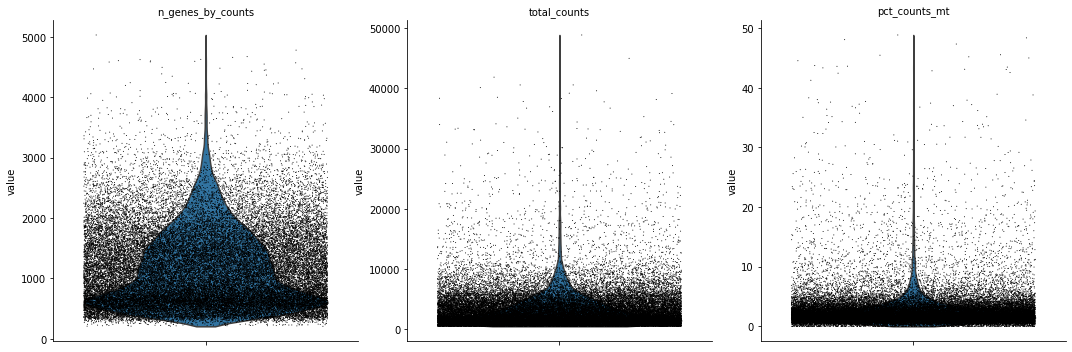

In [ ]:
sc.pl.violin(wirka, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
wirka = wirka[wirka.obs.n_genes_by_counts > 500, :]
wirka = wirka[wirka.obs.pct_counts_mt < 10, :]

In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/datasets')
gca = sc.read_h5ad('gca_annotated_raw.h5ad')
tissue = gca[gca.obs.tissue == 'tissue',:]
tissue = tissue[~(tissue.obs.anno.isnull()),:]
tissue.obs['source'] = 'gca'
tissue.obs['anno_seurat'] = tissue.obs['anno']
tissue.obs['anno_scanVI'] = tissue.obs['anno']
tissue.obs = tissue.obs[['anno', 'source', 'sample_id', 'diagnosis', 'anno_seurat', 'anno_scanVI', 'patient_id']]

Trying to set attribute `.obs` of view, copying.


In [ ]:
combined = tissue.concatenate(wirka, index_unique=None)

In [ ]:
combined.layers['counts'] = combined.X.copy()

In [ ]:
sc.pp.normalize_total(combined, target_sum=1e4)
sc.pp.log1p(combined)

combined.raw = combined

sc.pp.highly_variable_genes(
    combined,
    n_top_genes=3000,
    subset=True,
    flavor="seurat")

In [ ]:
scvi.data.setup_anndata(
    combined,
    layer="counts",
    categorical_covariate_keys=["sample_id", "source"],
    labels_key="anno_scanVI",
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["anno_scanVI"]                                          
INFO     Using data from adata.layers["counts"]                                              


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Successfully registered anndata object containing 56723 cells, 3000 vars, 1 batches,
         19 labels, and 0 proteins. Also registered 2 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


In [ ]:
model_combined = scvi.model.SCVI(combined)

In [ ]:
model_combined.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 141/141: 100%|██████████| 141/141 [07:58<00:00,  3.39s/it, loss=348, v_num=1]


In [ ]:
lvae = scvi.model.SCANVI.from_scvi_model(model_combined, "Unknown", adata=combined)

In [ ]:
lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [02:15<00:00,  6.76s/it, loss=431, v_num=1]


In [ ]:
combined.obs["C_scANVI"] = lvae.predict(combined)
combined.obsm["X_scANVI"] = lvae.get_latent_representation(combined)

In [ ]:
sc.pp.neighbors(combined, use_rep="X_scANVI")
sc.tl.umap(combined)

... storing 'anno' as categorical
... storing 'source' as categorical
... storing 'sample_id' as categorical
... storing 'diagnosis' as categorical
... storing 'anno_seurat' as categorical
... storing 'anno_scanVI' as categorical
... storing 'patient_id' as categorical
... storing 'C_scANVI' as categorical


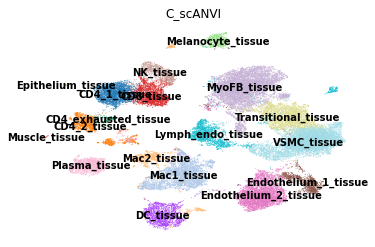

In [ ]:
sc.pl.umap(combined, color=["C_scANVI"], legend_loc = 'on data', ncols=1, frameon=False)

In [ ]:
combined.obs.C_scANVI = combined.obs.C_scANVI.map(lambda x: x.rstrip('_tissue'))

In [ ]:
combined.obs.C_scANVI.cat.categories

Index(['CD4_1', 'CD4_2', 'CD4_exhausted', 'CD8', 'DC', 'Endothelium_1',
       'Endothelium_2', 'Epithelium', 'Lymph_endo', 'Mac1', 'Mac2', 'Melanocy',
       'Muscl', 'MyoFB', 'NK', 'Plasma', 'Transitional', 'VSMC'],
      dtype='object')

In [ ]:
combined.obs.C_scANVI = combined.obs.C_scANVI.cat.reorder_categories(['CD4_1',
                                                                                    'CD4_2',
                                                                                    'CD4_exhausted',
                                                                                    'CD8',
                                                                                    'NK',
                                                                                    'Plasma',
                                                                                    'DC',
                                                                                    'Mac1',
                                                                                    'Mac2',
                                                                                    'VSMC',
                                                                                    'Transitional',
                                                                                    'MyoFB',
                                                                                    'Endothelium_1',
                                                                                    'Endothelium_2',
                                                                                    'Lymph_endo',
                                                                                    'Epithelium',
                                                                                    'Melanocy',
                                                                                    'Muscl'
                                                                                    ])

In [ ]:
temp = combined[combined.obs.source == 'wirka',:]

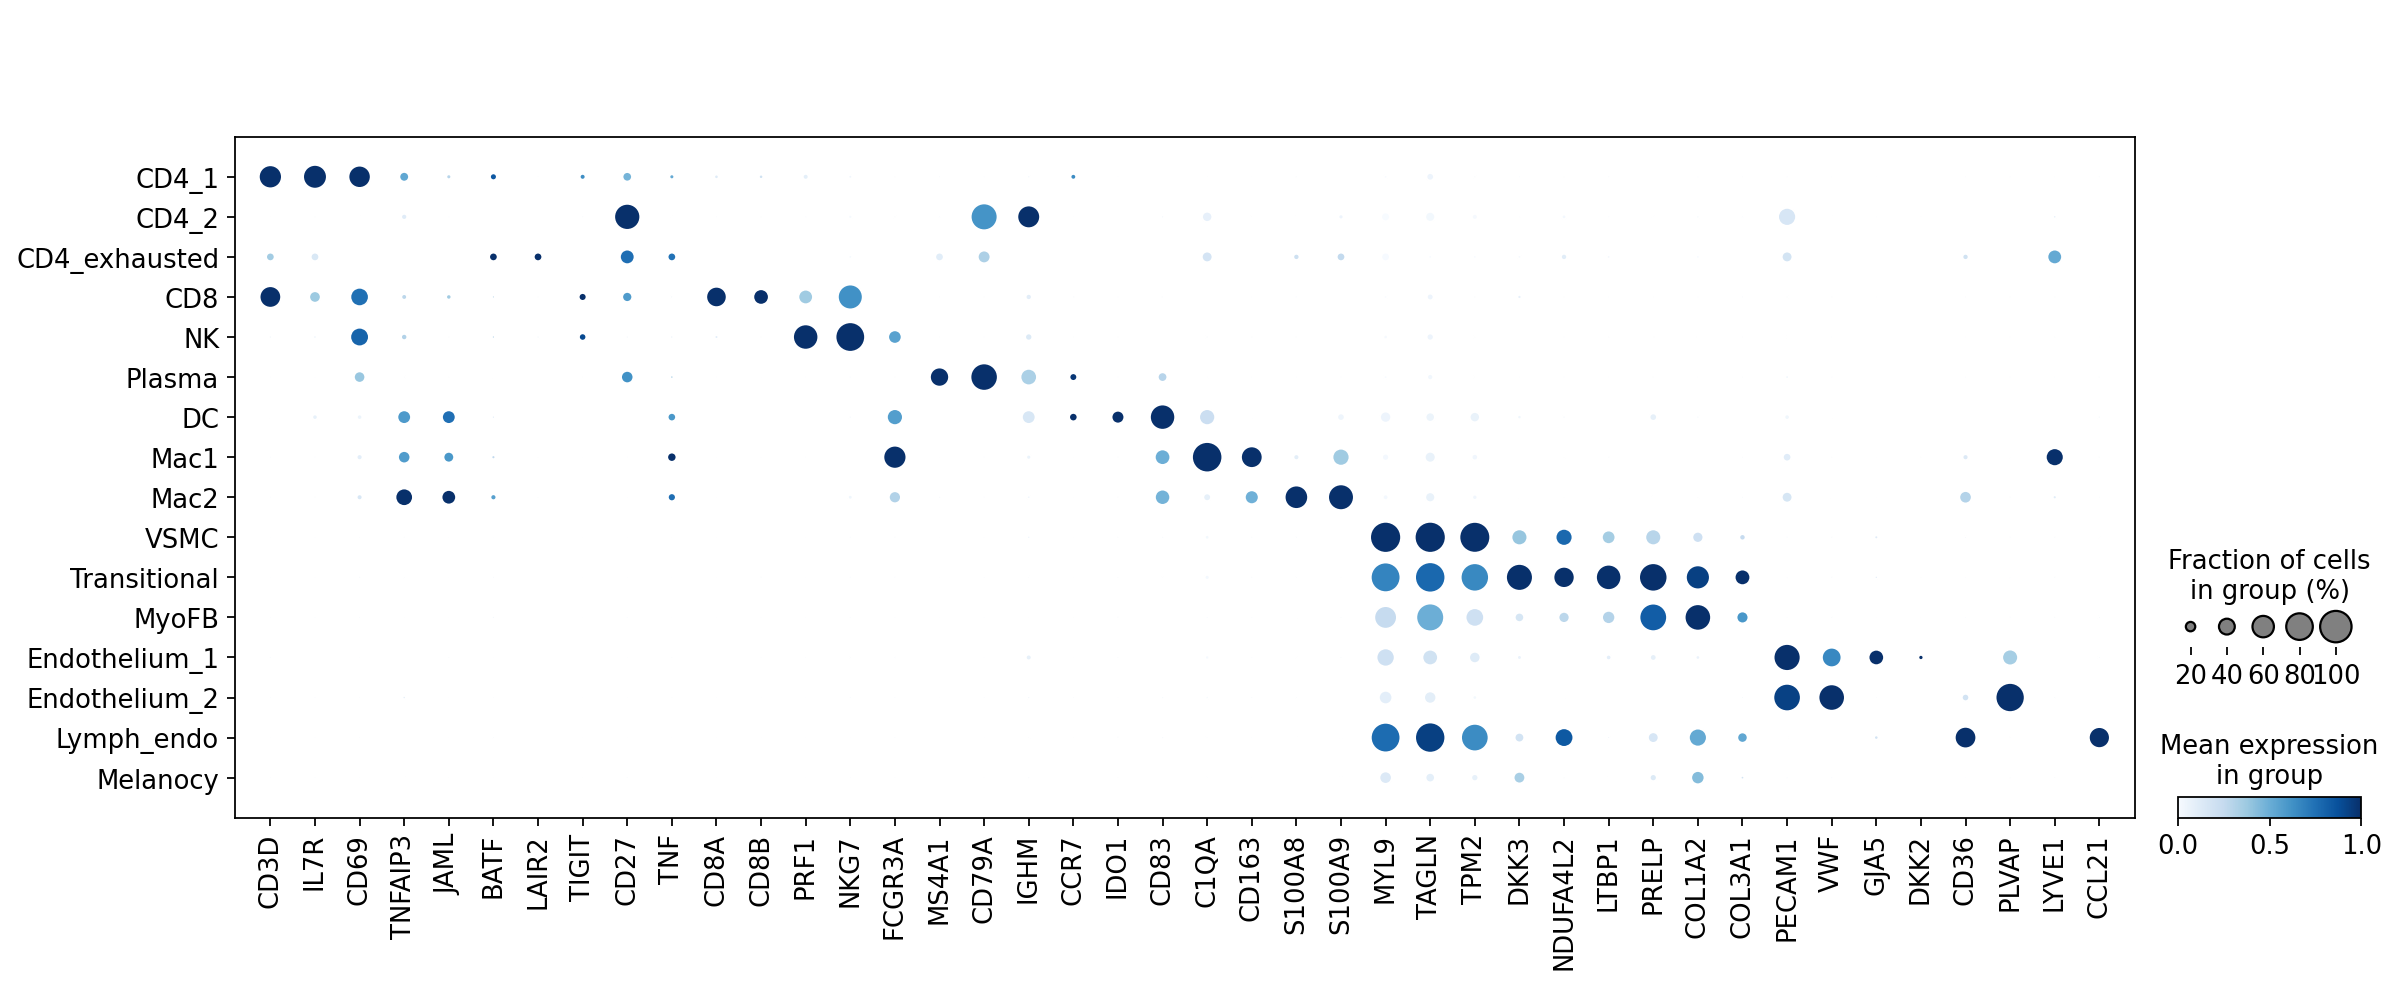

In [ ]:
sc.set_figure_params(dpi=80, dpi_save = 300)
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

sc.pl.DotPlot(temp, ['CD3D', 'IL7R', 
                                    'CD69', 'TNFAIP3',
                           'JAML', 'BATF',

                           'LAIR2', 'TIGIT','CD27', 'TNF',
                     'CD8A', 'CD8B',     
                     'PRF1', 'NKG7','FCGR3A',
                     'MS4A1', 'CD79A', 'IGHM', 
                     'CCR7', 'IDO1', 'CD83',
                     'C1QA', 'CD163',
                    'S100A8', 'S100A9',
                    'MYL9', 'TAGLN', 'TPM2',
                    'DKK3', 'NDUFA4L2', 'LTBP1',
                    'PRELP', 'COL1A2', 'COL3A1',
                    'PECAM1', 'VWF', 
                    'GJA5','DKK2',
                    'CD36', 'PLVAP',
                    'LYVE1', 'CCL21'], 
              groupby = 'C_scANVI', standard_scale = 'var').style(cmap='Blues',
                                                              dot_edge_color='white', 
                                                    dot_edge_lw=1).show()

In [ ]:
combined = combined[~(combined.obs.C_scANVI.isin(['Melanocy', 'Muscl', 'Epithelium'])),:]

In [ ]:
new_colors = np.array(combined.uns['C_scANVI_colors'])

new_colors[[0]] = '#85D4E3'  # CD4_1
new_colors[[1]] = '#F4B5BD'  # CD4_2
new_colors[[2]] = '#FD6467'  # CD4_exhausted
new_colors[[3]] = '#CDC08C'  # CD8
new_colors[[4]] = '#99ba9e'  # NK
new_colors[[5]] = '#9986A5'  # Plasma
new_colors[[6]] = '#79402E'  # DC
new_colors[[7]] = '#CCBA72'  # Mac1
new_colors[[8]] = '#d0e1f2'  # Mac2
new_colors[[9]] = '#2c7c94'  # VSMC
new_colors[[10]] = '#343c24'  # Transitional
new_colors[[11]] = '#fbe45b'  # MyoFB
new_colors[[12]] = '#D3DDDC'  # Endothelium1
new_colors[[13]] = '#FF7F00'  # Endothelium2
new_colors[[14]] = '#D95F02'  # Lymph_endo

combined.uns['C_scANVI_colors'] = new_colors


Trying to set attribute `.uns` of view, copying.


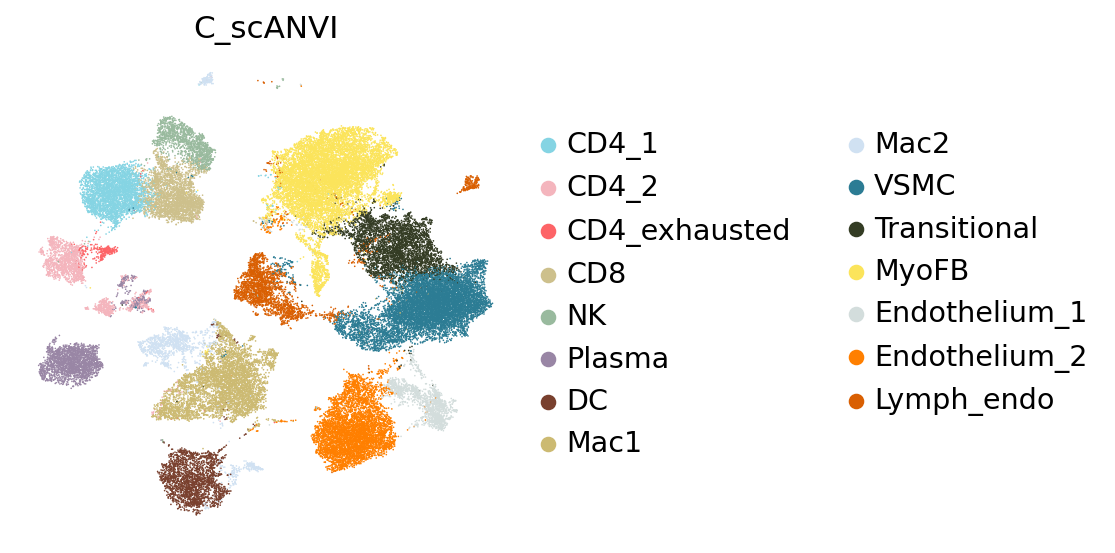

In [ ]:
sc.pl.umap(combined, color=["C_scANVI"], legend_loc = 'right margin', ncols=1, frameon=False)

In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/external_data')
combined.obs[['C_scANVI']].to_csv('wirka_C_scANVI_anno.csv')

In [ ]:
#checkpoint - integrated object with transferred labels with scanVI

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/external_data')
combined.write('wirka_gca_combined_raw_annotated.h5ad', compression = 'gzip')
model_combined.save("combined_model/", overwrite = True)

In [ ]:


***Restart***



In [ ]:
##Restart
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/external_data')
combined = sc.read_h5ad('wirka_gca_combined_raw_annotated.h5ad')
model_combined = scvi.model.SCVI.load("combined_model/", combined, use_gpu=True)

INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs']                        
INFO     Successfully registered anndata object containing 55558 cells, 3000 vars, 1 batches,
         19 labels, and 0 proteins. Also registered 2 extra categorical covariates and 0     
         extra continuous covariates.                                                        


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
combined.obs['C_scANVI_diagnosis'] = combined.obs['C_scANVI'].astype(str) + '_' + combined.obs['diagnosis'].astype(str)
combined.obs['source_diagnosis'] = combined.obs['source'].astype(str) + '_' + combined.obs['diagnosis'].astype(str)
combined.obs['C_scANVI_source'] = combined.obs['C_scANVI'].astype(str) + '_' + combined.obs['source'].astype(str)

In [ ]:
de_transitional = model_combined.differential_expression(
    groupby="C_scANVI",
    group1="Transitional")

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


In [ ]:
de_temp = de_transitional.loc[(de_transitional.lfc_mean > 1.5) & (de_transitional.non_zeros_proportion1 >0.3) & (de_transitional['is_de_fdr_0.05'] == True)]

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'C_scANVI_diagnosis' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'source_diagnosis' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'C_scANVI_source' as categorical


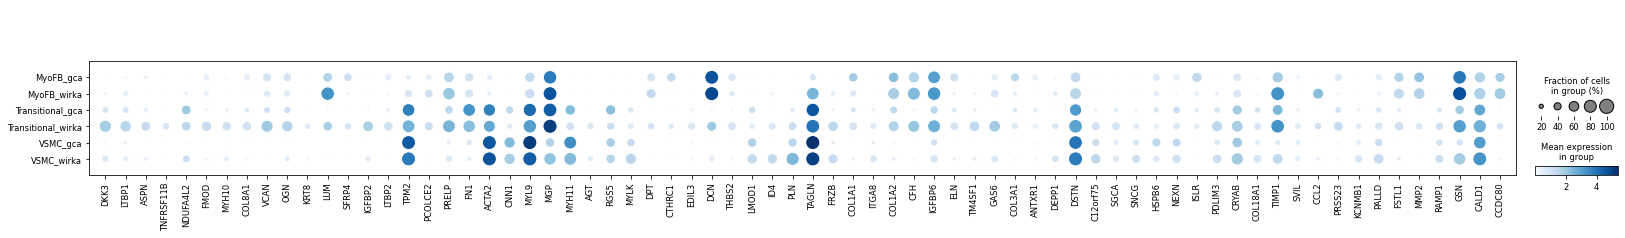

In [ ]:
temp = combined[combined.obs.C_scANVI.isin(['MyoFB', 'Transitional', 'VSMC']),:]

sc.pl.DotPlot(temp, de_temp.index.tolist(), 
              groupby = 'C_scANVI_source').style(cmap='Blues', dot_edge_color='white', 
                                                    dot_edge_lw=1).show()

In [ ]:
de_myoFB = model_combined.differential_expression(
    groupby="C_scANVI_diagnosis",
    group1="MyoFB_positive",
    group2="MyoFB_negative"
)

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/stats')
de_myoFB.to_csv('scVI_myoFB_wirka_pos_vs_neg.csv')

In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/stats')
scVI_degs = pd.read_csv('scVI_myoFB_wirka_pos_vs_neg.csv', index_col =0)

In [ ]:
scVI_temp = scVI_degs.loc[(scVI_degs.lfc_mean > 1.5) & (scVI_degs.non_zeros_proportion1 >0.25) & (scVI_degs['is_de_fdr_0.05'] == True)]

In [ ]:
genes_to_plot = ['HMGN4',
 'TEN1',
 'CTHRC1',
 'CTSK',
 'SFRP4',
 'COL8A1',
 'COL3A1',
 'CPXM1',
 'COL1A1',
 'COL5A1',
 'FBN1',
 'DEFB1',
 'CD109',
 'COL6A3',
 'ELN',
 'MME',
 'TBX15',
 'PI16',
 'HSPA1A',
 'CLEC3B', 'CD248']

Trying to set attribute `.obs` of view, copying.
... storing 'C_scANVI_diagnosis' as categorical
... storing 'C_scANVI_source' as categorical


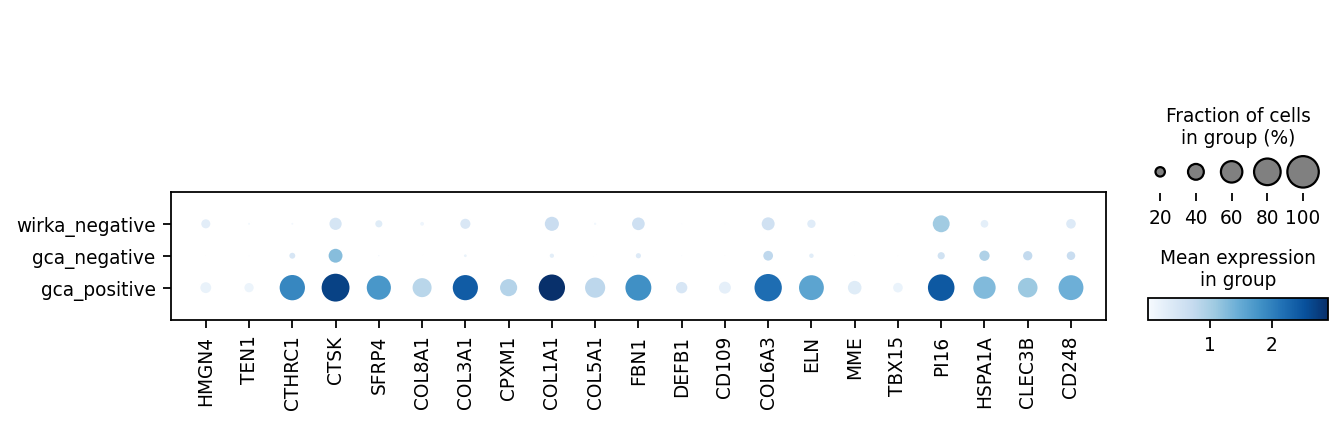

In [ ]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, fontsize = 10)

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

temp = combined[combined.obs.C_scANVI == 'MyoFB',:]

temp.obs.source_diagnosis = temp.obs.source_diagnosis.astype('category')
temp.obs.source_diagnosis.cat.reorder_categories(['wirka_negative', 'gca_negative', 'gca_positive'], inplace = True)

sc.pl.DotPlot(temp, genes_to_plot, 
              groupby = 'source_diagnosis').style(cmap='Blues', dot_edge_color='white', 
                                                    dot_edge_lw=1).savefig('myoFB_wirka_gca_comparison_dotplot.png')

Trying to set attribute `.obs` of view, copying.
... storing 'C_scANVI_diagnosis' as categorical


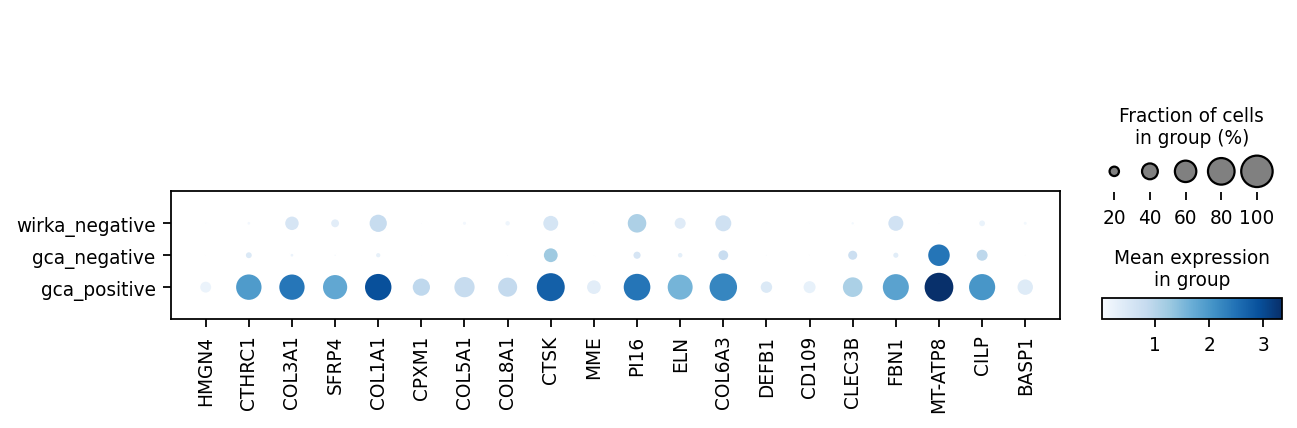

In [ ]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, fontsize = 10)

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

temp = combined[combined.obs.C_scANVI == 'MyoFB',:]

temp.obs.source_diagnosis = temp.obs.source_diagnosis.astype('category')
temp.obs.source_diagnosis.cat.reorder_categories(['wirka_negative', 'gca_negative', 'gca_positive'], inplace = True)

sc.pl.DotPlot(temp, scVI_temp.head(20).index.tolist(), 
              groupby = 'source_diagnosis').style(cmap='Blues', dot_edge_color='white', 
                                                    dot_edge_lw=1).savefig('myoFB_wirka_gca_comparison_dotplot.png')

In [ ]:
#import DESeq2 stats

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/stats')
scVI_degs = pd.read_csv('scVI_myoFB_wirka_pos_vs_neg.csv', index_col = 0)
DESeq_degs = pd.read_csv('DESeq_myoFB_wirka_pos_vs_neg.csv', index_col = 0)

In [ ]:
#Filter both DESeq2 and scVI stats using similar parameters (significant, 1.5>log2FC)

DESeq_temp = DESeq_degs[(DESeq_degs.padj<0.05) & (DESeq_degs.log2FoldChange>0.584)]
scVI_temp = scVI_degs.loc[(scVI_degs.lfc_mean > 1.5) & (scVI_degs.non_zeros_proportion1 >0.25) & (scVI_temp['is_de_fdr_0.05'] == True)]

In [ ]:
#get the intersect of both gene lists

temp_genelist = set(scVI_temp.index.tolist()) & set(DESeq_temp.index.tolist())

Trying to set attribute `.obs` of view, copying.
... storing 'C_scANVI_diagnosis' as categorical


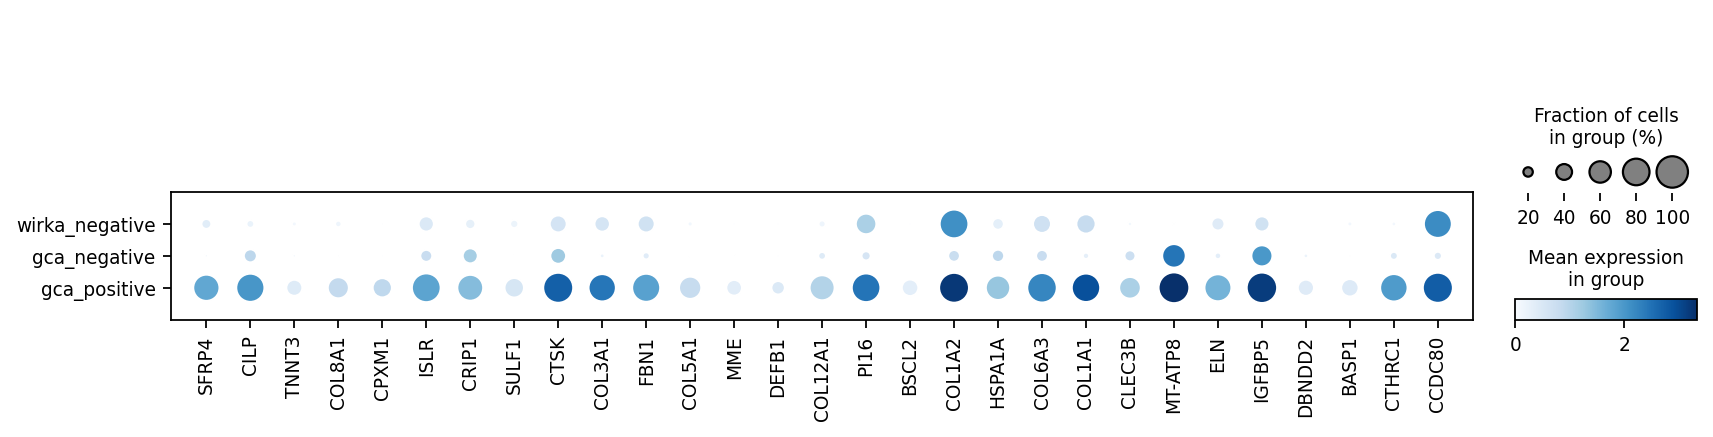

In [ ]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, fontsize = 10)

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

temp = combined[combined.obs.C_scANVI == 'MyoFB',:]

temp.obs.source_diagnosis = temp.obs.source_diagnosis.astype('category')
temp.obs.source_diagnosis.cat.reorder_categories(['wirka_negative', 'gca_negative', 'gca_positive'], inplace = True)

sc.pl.DotPlot(temp, list(temp_genelist), 
              groupby = 'source_diagnosis').style(cmap='Blues', dot_edge_color='white', 
                                                    dot_edge_lw=1).savefig('myoFB_wirka_gca_comparison_dotplot_DESeq2.png')

In [ ]:


***Plot absence of DCs in atherosclerosis***



In [ ]:
##Restart
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/external_data')
combined = sc.read_h5ad('wirka_gca_combined_raw_annotated.h5ad')
model_combined = scvi.model.SCVI.load("combined_model/", combined, use_gpu=True)

INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs']                        
INFO     Successfully registered anndata object containing 55558 cells, 3000 vars, 1 batches,
         19 labels, and 0 proteins. Also registered 2 extra categorical covariates and 0     
         extra continuous covariates.                                                        


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
combined.obs['combined'] = combined.obs.C_scANVI.astype(str) + '_' + combined.obs.source.astype(str)

In [ ]:
combined.obs.combined.cat.categories

Index(['CD4_1_gca', 'CD4_1_wirka', 'CD4_2_gca', 'CD4_2_wirka',
       'CD4_exhausted_gca', 'CD4_exhausted_wirka', 'CD8_gca', 'CD8_wirka',
       'DC_gca', 'DC_wirka', 'Endothelium_1_gca', 'Endothelium_1_wirka',
       'Endothelium_2_gca', 'Endothelium_2_wirka', 'Lymph_endo_gca',
       'Lymph_endo_wirka', 'Mac1_gca', 'Mac1_wirka', 'Mac2_gca', 'Mac2_wirka',
       'MyoFB_gca', 'MyoFB_wirka', 'NK_gca', 'NK_wirka', 'Plasma_gca',
       'Plasma_wirka', 'Transitional_gca', 'Transitional_wirka', 'VSMC_gca',
       'VSMC_wirka'],
      dtype='object')

In [ ]:
include = combined.obs['combined'].cat.categories
include[include.str.contains('wirka')]

Index(['CD4_1_wirka', 'CD4_2_wirka', 'CD4_exhausted_wirka', 'CD8_wirka',
       'DC_wirka', 'Endothelium_1_wirka', 'Endothelium_2_wirka',
       'Lymph_endo_wirka', 'Mac1_wirka', 'Mac2_wirka', 'MyoFB_wirka',
       'NK_wirka', 'Plasma_wirka', 'Transitional_wirka', 'VSMC_wirka'],
      dtype='object')

In [ ]:
combined.obs.combined = combined.obs.combined.cat.reorder_categories(['CD4_1_gca',
                                                                                    'CD4_2_gca',
                                                                                    'CD4_exhausted_gca',
                                                                                    'CD8_gca',
                                                                                    'NK_gca',
                                                                                    'Plasma_gca',
                                                                                    'DC_gca',
                                                                                    'Mac1_gca',
                                                                                    'Mac2_gca',
                                                                                    'VSMC_gca',
                                                                                    'Transitional_gca',
                                                                                    'MyoFB_gca',
                                                                                    'Endothelium_1_gca',
                                                                                    'Endothelium_2_gca',
                                                                                    'Lymph_endo_gca',
                                                                      'CD4_1_wirka',
                                                                                    'CD4_2_wirka',
                                                                                    'CD4_exhausted_wirka',
                                                                                    'CD8_wirka',
                                                                                    'NK_wirka',
                                                                                    'Plasma_wirka',
                                                                                    'DC_wirka',
                                                                                    'Mac1_wirka',
                                                                                    'Mac2_wirka',
                                                                                    'VSMC_wirka',
                                                                                    'Transitional_wirka',
                                                                                    'MyoFB_wirka',
                                                                                    'Endothelium_1_wirka',
                                                                                    'Endothelium_2_wirka',
                                                                                    'Lymph_endo_wirka'
                                                                                    ])

In [ ]:
new_colors = np.array(combined.uns['combined_colors'])

new_colors[[0]] = '#85D4E3'  # CD4_1
new_colors[[1]] = '#F4B5BD'  # CD4_2
new_colors[[2]] = '#FD6467'  # CD4_exhausted
new_colors[[3]] = '#CDC08C'  # CD8
new_colors[[4]] = '#99ba9e'  # NK
new_colors[[5]] = '#9986A5'  # Plasma
new_colors[[6]] = '#79402E'  # DC
new_colors[[7]] = '#CCBA72'  # Mac1
new_colors[[8]] = '#d0e1f2'  # Mac2
new_colors[[9]] = '#2c7c94'  # VSMC
new_colors[[10]] = '#343c24'  # Transitional
new_colors[[11]] = '#fbe45b'  # MyoFB
new_colors[[12]] = '#D3DDDC'  # Endothelium1
new_colors[[13]] = '#FF7F00'  # Endothelium2
new_colors[[14]] = '#D95F02'  # Lymph_endo

new_colors[[15]] = '#85D4E3'  # CD4_1
new_colors[[16]] = '#F4B5BD'  # CD4_2
new_colors[[17]] = '#FD6467'  # CD4_exhausted
new_colors[[18]] = '#CDC08C'  # CD8
new_colors[[19]] = '#99ba9e'  # NK
new_colors[[20]] = '#9986A5'  # Plasma
new_colors[[21]] = '#79402E'  # DC
new_colors[[22]] = '#CCBA72'  # Mac1
new_colors[[23]] = '#d0e1f2'  # Mac2
new_colors[[24]] = '#2c7c94'  # VSMC
new_colors[[25]] = '#343c24'  # Transitional
new_colors[[26]] = '#fbe45b'  # MyoFB
new_colors[[27]] = '#D3DDDC'  # Endothelium1
new_colors[[28]] = '#FF7F00'  # Endothelium2
new_colors[[29]] = '#D95F02'  # Lymph_endo

combined.uns['combined_colors'] = new_colors


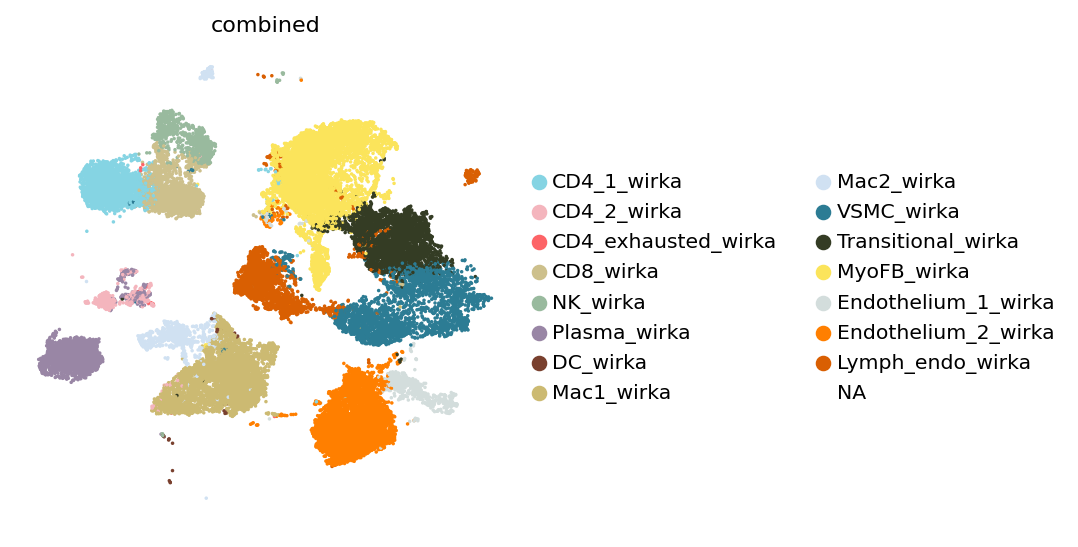

In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, fontsize = 10)
sc.pl.umap(combined, color=["combined"], legend_loc = 'right margin', ncols=1, frameon=False, size = 10, groups = include[include.str.contains('wirka')].tolist(), save = 'DC_comparison_wirka.png', na_color = 'white')

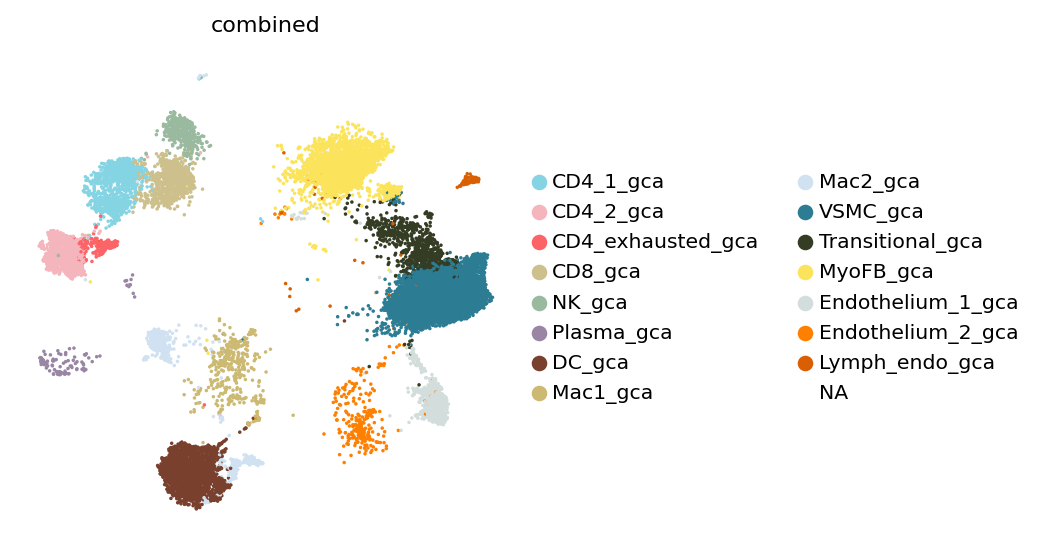

In [ ]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, fontsize = 10)
sc.pl.umap(combined, color=["combined"], legend_loc = 'right margin', ncols=1, frameon=False, size = 10, groups = include[include.str.contains('gca')].tolist(), save = 'DC_comparison_gca.png', na_color = 'white')

In [ ]:
wirka = combined[combined.obs.source == 'wirka',:]
gca = combined[combined.obs.source == 'gca',:]

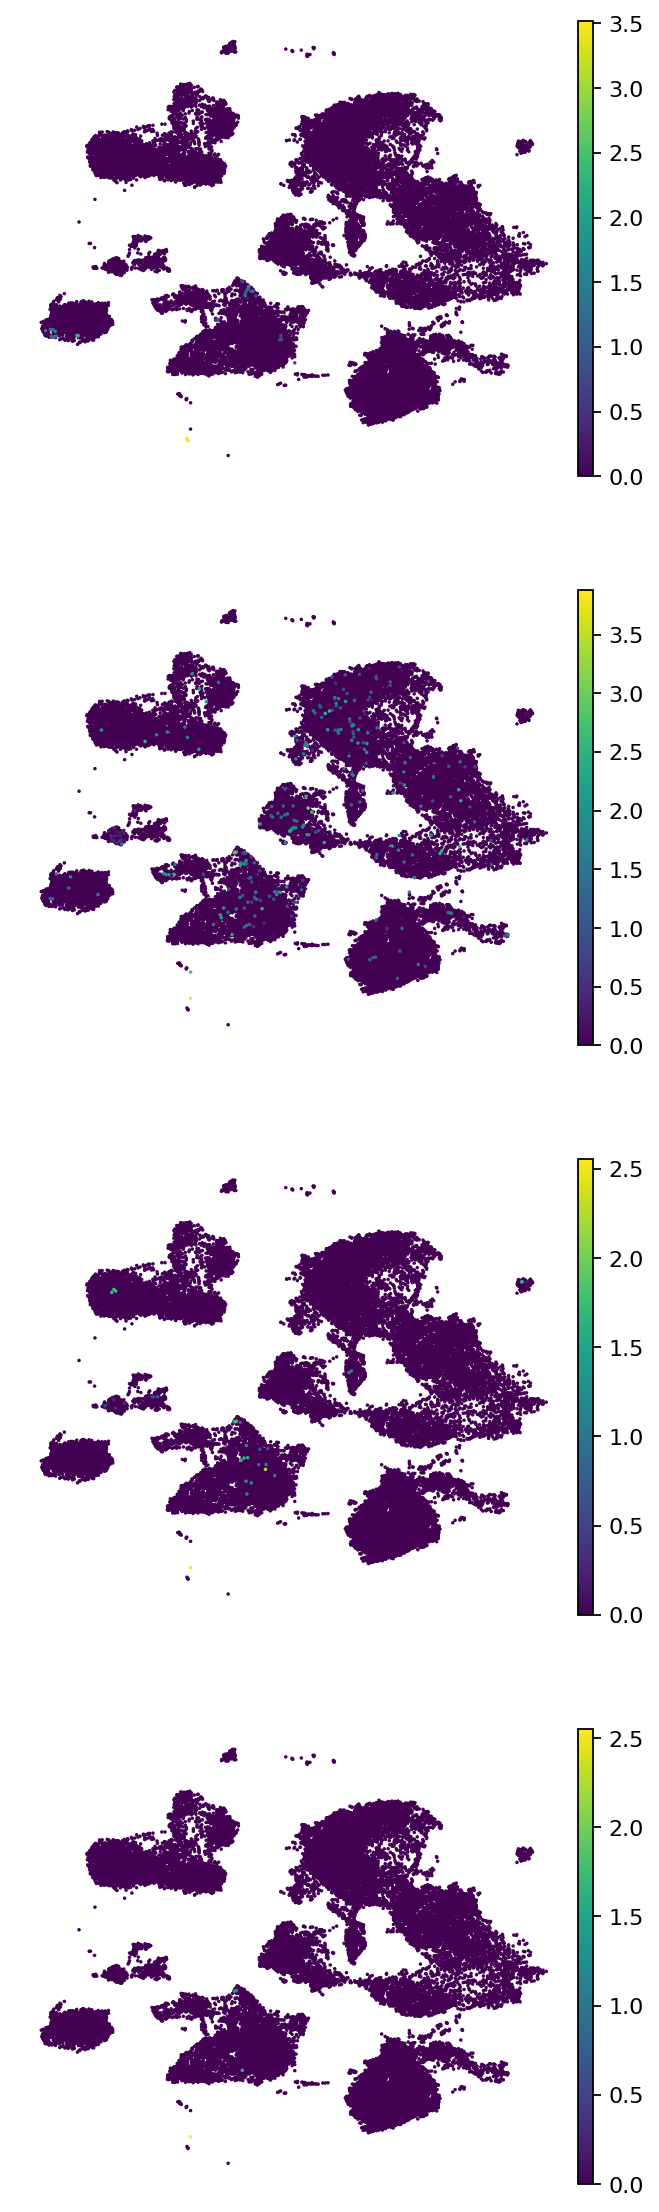

In [ ]:
sc.pl.umap(wirka, color=["CCL22", 'IDO1', 'LAMP3', 'LAD1'], legend_loc = 'right margin', ncols=1, frameon=False, size = 10, save = 'DC_marker_comparison_wirka.png', title = ['','', '', ''])

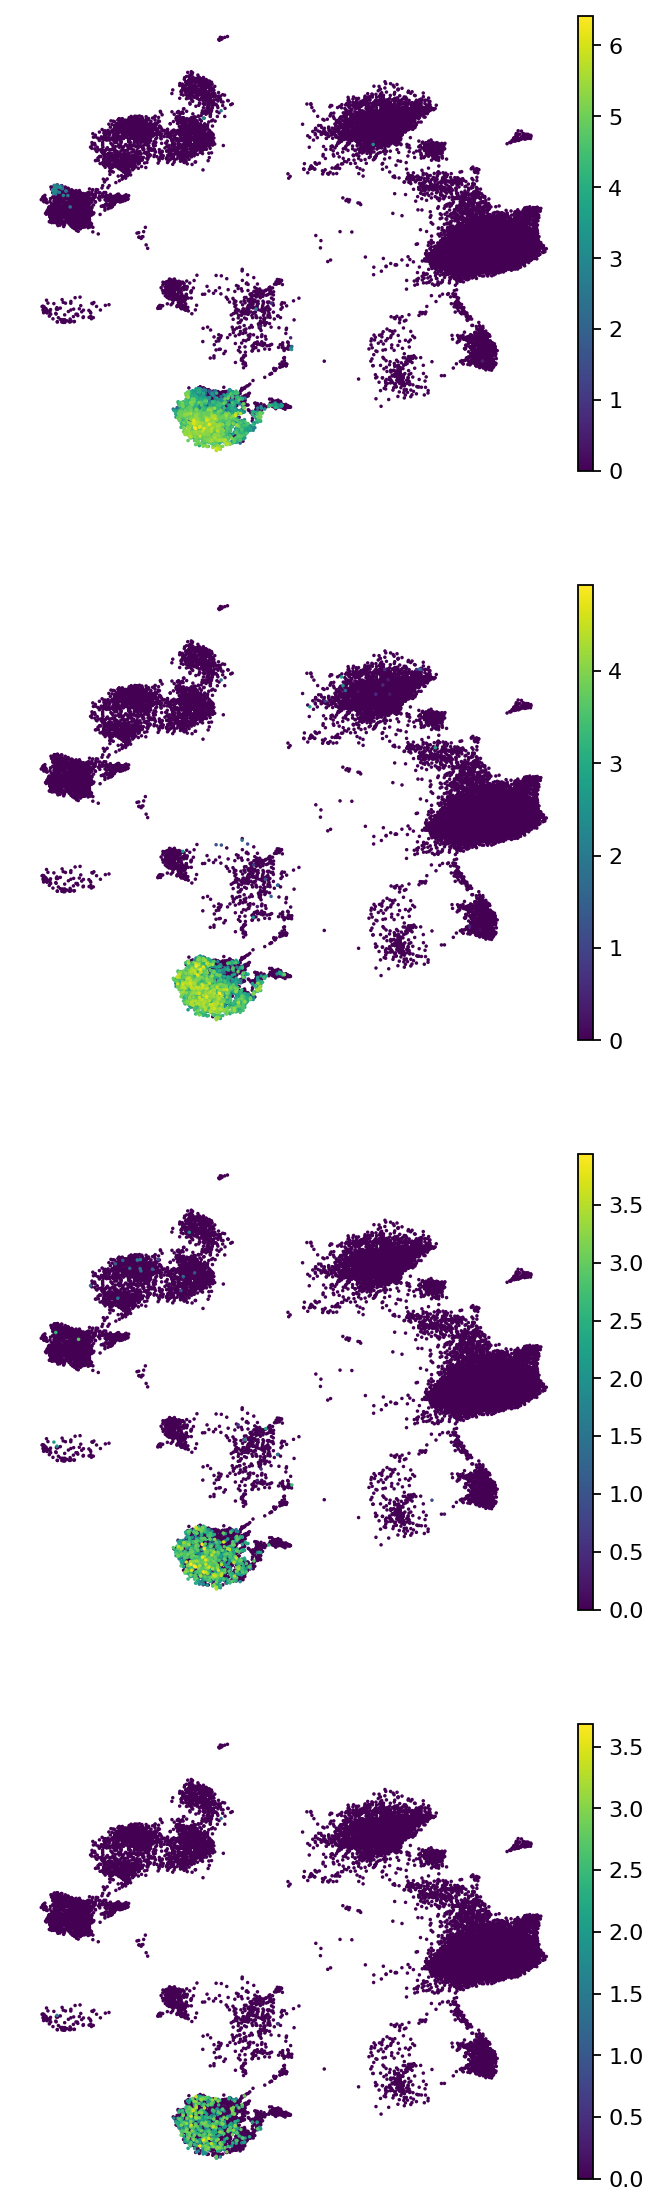

In [ ]:
sc.pl.umap(gca, color=['CCL22', "IDO1", 'LAMP3', 'LAD1'], legend_loc = 'right margin', ncols=1, frameon=False, size = 10, save = 'DC_marker_comparison_gca.png', title = ['','', '', ''])

In [ ]:

***Marker genes across tissues***



In [ ]:
##Restart
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/external_data')
combined = sc.read_h5ad('wirka_gca_combined_raw_annotated.h5ad')
model_combined = scvi.model.SCVI.load("combined_model/", combined, use_gpu=True)

INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs']                        
INFO     Successfully registered anndata object containing 55558 cells, 3000 vars, 1 batches,
         19 labels, and 0 proteins. Also registered 2 extra categorical covariates and 0     
         extra continuous covariates.                                                        


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
combined.obs['combined'] = combined.obs.C_scANVI.astype(str) + '_' + combined.obs.source.astype(str)

In [ ]:
combined.obs.C_scANVI = combined.obs.C_scANVI.cat.reorder_categories(['CD4_1',
                                                                                    'CD4_2',
                                                                                    'CD4_exhausted',
                                                                                    'CD8',
                                                                                    'NK',
                                                                                    'Plasma',
                                                                                    'DC',
                                                                                    'Mac1',
                                                                                    'Mac2',
                                                                                    'VSMC',
                                                                                    'Transitional',
                                                                                    'MyoFB',
                                                                                    'Endothelium_1',
                                                                                    'Endothelium_2',
                                                                                    'Lymph_endo'])

In [ ]:
wirka = combined[(combined.obs.source == 'wirka') & (combined.obs.C_scANVI.isin(['VSMC','Transitional', 'MyoFB'])),:]
gca = combined[(combined.obs.source == 'gca') & (combined.obs.C_scANVI.isin(['VSMC','Transitional', 'MyoFB'])),:]

In [ ]:
de_transitional = model_combined.differential_expression(
    groupby="C_scANVI",
    group1="Transitional")

DE...: 100%|██████████| 1/1 [00:04<00:00,  4.90s/it]


In [ ]:
de_temp = de_transitional.loc[(de_transitional.lfc_mean > 1.5) & (de_transitional.non_zeros_proportion1 >0.3) & (de_transitional['is_de_fdr_0.05'] == True)]

In [ ]:
temp2 = de_transitional.loc[(de_transitional.lfc_mean > 1.5) & (de_transitional.non_zeros_proportion1 >0.3) & (de_transitional['is_de_fdr_0.05'] == True)]

In [ ]:
wirka.obs.combined = wirka.obs.combined.cat.reorder_categories(['VSMC_wirka', 'Transitional_wirka', 'MyoFB_wirka'])
gca.obs.combined = gca.obs.combined.cat.reorder_categories(['VSMC_gca', 'Transitional_gca', 'MyoFB_gca'])

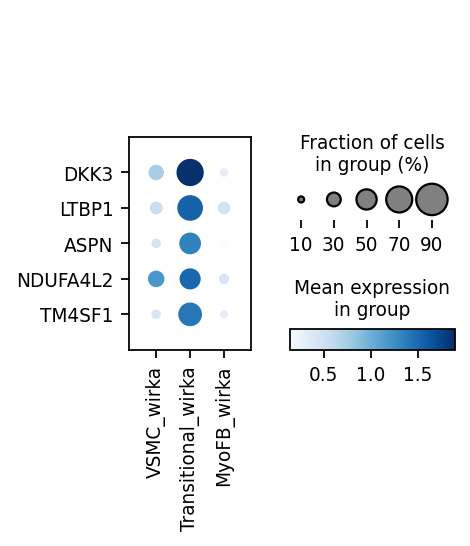

In [ ]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, fontsize = 10)

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

sc.pl.DotPlot(wirka, ['DKK3', 'LTBP1', 'ASPN', 'NDUFA4L2', 'TM4SF1'], 
              groupby = 'combined').style(cmap='Blues', dot_edge_color='white', 
                                                    dot_edge_lw=1).swap_axes().savefig('wirka_transitional_markers.png')

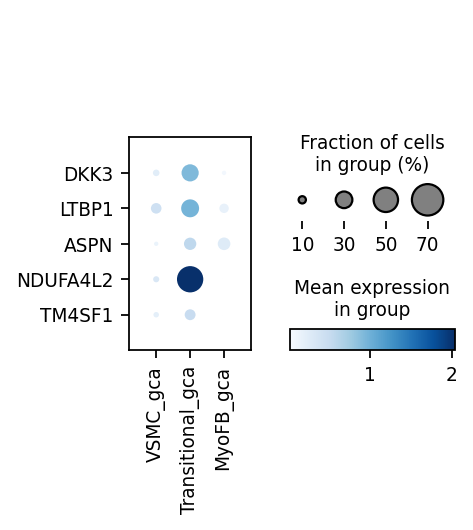

In [ ]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, fontsize = 10)

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

sc.pl.DotPlot(gca, ['DKK3', 'LTBP1', 'ASPN', 'NDUFA4L2', 'TM4SF1'], 
              groupby = 'combined').style(cmap='Blues', dot_edge_color='white', 
                                                    dot_edge_lw=1).swap_axes().savefig('gca_transitional_markers.png')